# Le challenge

**Objectif**

L'objectif de ce challenge est de prévoir la consommation électrique de l’île d'Ouessant à 8 jours, en s’aidant des données suivantes : 
* un an de données de consommation historiques, à la maille horaire (conso_train.csv), 
* un an de données météorologiques à la maille tri-horaire, issues de la proche station météorologique de Brest (meteo_train.csv), 
* une semaine de données météorologiques à la maille tri-horaire, issues de la même station et faisant office de prédiction météorologique (meteo_prev.csv).

Au délà de cet aspect prévision, ce challenge s'inscrit également dans le cadre d'un projet rouge.

**Methodologies**

Il s'agit bien évidement d'un ***problème de régression*** à partir de données qui sont des ***séries temporelles***. Une des solutions classique de prévisions à partir de serie temporelles reste les modèles ***ARMA*** et ***ARIMA***. Etant donnée que notre objectif est d'explorer les méthodologies de machine learning, je me contenterais les outils disponible dans ce champ d'application. Une des techniques (après quelques recherche) qui ressort le plus souvent pour le traitement de ce problème est le ***reseau de neuronne recurants (LSTM)***. Je partirais donc sur ce postulat que ce modèle pourrait donner de bon résultats et plus tard explorer les deux autres modèles que je juges utiles (***SVM*** et ***arbre de decision***).

Pour évaluer les modèles je me contenterais d'utiliser les critères d'évaluation utilisé dans le cadre du challenge, savoir, l'erreur absolue moyenne en pourcentage (***MAPE***), puis  l'erreur quadratique moyenne (***RMSE***)

La première hypothèse faite sera de considérer que les prévisions météorologiques comme parfaites.

# Les données

Les données sont fournies par les organisateurs du challenge. Elles ont été téléchargé sur un lien avait été mis à disposition pour une durée limitée. Les données sont constituées comme suit:


*   conso_train : qui contient toutes les données de consomation (puissance en Kwh). C'est notre variable à predire
*   meteo_train : qui contient toutes les données météorologiques. Ceux sont nos prédicteurs
*   meteo_train : qui contient toutes les données météorologiques pour lesquelles il faudra fournir des prévisions
*   sample_solution : qui contient un example de comment notre solution prévisionnelle final devra être soumise


# Packages

**installation**

In [2]:
!pip install --upgrade PyDrive
!pip install --upgrade keras
!pip install --upgrade google
!pip install --upgrade windrose

    100% |████████████████████████████████| 993kB 1.1MB/s 
    100% |████████████████████████████████| 256kB 3.4MB/s 
Requirement already up-to-date: google-api-python-client>=1.2 in /usr/local/lib/python3.6/dist-packages (from PyDrive)
Requirement already up-to-date: oauth2client>=4.0.0 in /usr/local/lib/python3.6/dist-packages (from PyDrive)
Requirement already up-to-date: six<2dev,>=1.6.1 in /usr/local/lib/python3.6/dist-packages (from google-api-python-client>=1.2->PyDrive)
    100% |████████████████████████████████| 225kB 4.1MB/s 
Requirement already up-to-date: uritemplate<4dev,>=3.0.0 in /usr/local/lib/python3.6/dist-packages (from google-api-python-client>=1.2->PyDrive)
Requirement already up-to-date: rsa>=3.1.4 in /usr/local/lib/python3.6/dist-packages (from oauth2client>=4.0.0->PyDrive)
Requirement already up-to-date: pyasn1>=0.1.7 in /usr/local/lib/python3.6/dist-packages (from oauth2client>=4.0.0->PyDrive)
Requirement already up-to-date: pyasn1-modules>=0.0.5 in /usr/local/

    100% |████████████████████████████████| 50.0MB 28kB/s 
Requirement already up-to-date: numpy>=1.9.1 in /usr/local/lib/python3.6/dist-packages (from keras)
  Found existing installation: scipy 0.19.1
    Uninstalling scipy-0.19.1:
      Successfully uninstalled scipy-0.19.1
Requirement already up-to-date: beautifulsoup4 in /usr/local/lib/python3.6/dist-packages (from google)
  Running setup.py bdist_wheel for google ... - done
  Stored in directory: /content/.cache/pip/wheels/b0/bb/f6/0206fbd328c2ac43c4ef4eb98a7a381449b9c08e92415bf64c
Successfully built google
    100% |████████████████████████████████| 12.6MB 109kB/s 
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (from windrose)
    100% |████████████████████████████████| 512kB 2.4MB/s 
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /usr/local/lib/python3.6/dist-packages (from matplotlib->windrose)
    100% |████████████████████████████████| 215kB 4.7MB/s 
Requirement

**Importation**

In [0]:
import sys
import pytz # Pour retablir les dates au bon time zone
import datetime # Pour la manipulation des dates

import numpy as np # Pour la manipulation des tableaux ndarray
import pandas as pd # Pour la manipulationd des données DataFrame
import seaborn as sns # Pour la visualisation des données
import matplotlib.pyplot as plt # Pour la visualisation
%matplotlib inline
from windrose import WindroseAxes # Pour la visualisation des données méteo

from io import StringIO # Pour la lectue des données
from numpy import concatenate # Pour la concatenation de tableau ndarray
from pandas import concat # Pour la concatenation de DataFrame

from google.colab import auth # Pour utiliser Google Colab
from pydrive.auth import GoogleAuth # Pour l'authentification sur Google Drive
from pydrive.drive import GoogleDrive # Pour avoir accès à Google Drive
from oauth2client.client import GoogleCredentials

from statsmodels.graphics.tsaplots import plot_acf

from keras.optimizers import SGD # Optimizer pour nos modèles
from keras.models import Sequential # Pour faire un modèle sequentiel
from keras.layers import Dense, LSTM # Pour faire un réseau de neuronne recursif
from keras.callbacks import EarlyStopping, ModelCheckpoint # Pour améliorer notre modèle et l'arreter prématurerment

from sklearn.preprocessing import MinMaxScaler, StandardScaler # Pour faire de la normalisation
from sklearn.model_selection import train_test_split # Pour faire le split des données
from sklearn.metrics import mean_squared_error, mean_absolute_error # Pour évaluer les modèles
from sklearn.ensemble import RandomForestRegressor

# Chargement des données à partir de Google Drive

In [0]:
auth.authenticate_user()

gauth = GoogleAuth()

gauth.credentials = GoogleCredentials.get_application_default()

drive = GoogleDrive(gauth)

meteo_train_loaded = {"id":"1QBj8Mm0W1ICu-XSxCe-T-pMA8tSFSryq", "data": None} # id Google Drive des données meteo train

conso_train_loaded = {"id":"1-LdkZdni-EBxdr_CIOq-JYfkGrZz11Yg", "data": None} # id Google Drive des données conso train

meteo_prev_loaded = {"id":"1jMBVJn3imRhDgRNkDB6CNy1ATq5up9mI", "data": None}  # id Google Drive des données meteo prev

files = [meteo_train_loaded, conso_train_loaded, meteo_prev_loaded]

for file in files:
  
  downloaded = drive.CreateFile({'id': file["id"]})
  
  downloaded_io = StringIO(downloaded.GetContentString())
  
  file["data"] = pd.read_csv(downloaded_io, sep=";")

meteo_train = meteo_train_loaded["data"].copy()
conso_train = conso_train_loaded["data"].copy()
meteo_prev = meteo_prev_loaded["data"].copy()

# Exploration des données

In [5]:
print("="*35, "Info", "="*35)
print(meteo_train.info())

print("="*32, "Stats Desc", "="*32)
print(meteo_train.describe())

=================================== Info ===================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2928 entries, 0 to 2927
Data columns (total 12 columns):
Date UTC           2928 non-null object
T¬∞ (C)            2864 non-null float64
P (hPa)            2864 non-null float64
HR (%)             2864 non-null float64
P.ros√©e (¬∞C)     2864 non-null float64
Visi (km)          2864 non-null float64
Vt. moy. (km/h)    2864 non-null float64
Vt. raf. (km/h)    2861 non-null float64
Vt. dir (¬∞)       2864 non-null float64
RR 3h (mm)         2592 non-null float64
Neige (cm)         971 non-null float64
Nebul. (octats)    2519 non-null float64
dtypes: float64(11), object(1)
memory usage: 274.6+ KB
None
================================ Stats Desc ================================
           T¬∞ (C)      P (hPa)       HR (%)  P.ros√©e (¬∞C)    Visi (km)  \
count  2864.000000  2864.000000  2864.000000     2864.000000  2864.000000   
mean     12.365154  1016.839525    

**Remarques** : 
* On peut remarquer qu'on a ***12 variables*** et ***2928 points*** de données.
* Les noms des variables ne sont pas très explicites, mais on peut en identifier certaines.
* la variables ***Date UTC n'a aucune valeurs manquantes***, mais les autres en ont exactement le même nombre à l'exception de quelques unes.
* Ces données méteorologiques étant à la maille tri-horaire, on peut supposer qu'il y a donc 8 observations par jour. Ce qui peut se confirmer en divisant 2928 par 8, ce qui donne exactement 366 et confirme que les données correspondent à une année entière.
* La varible ***Date UTC a pour type object***, il faudra donc y remedier.
* on a ***2928 - 2856 = 72 données manquantes***.*** 64 / 8 qui correspond à 9 jours*** de données que j'essayerai d'identifier
* Il faudra determiner à quoi correspond les variables suivantes : ***HR (%), P.ros√©e (¬∞C), RR 3h (mm), Neige (cm), Nebul. (octats),***.
* La variable ***Neige (cm)*** qui est sensé être en centimètre est presque tout le temps égale à 0 si elle n'est pas manquante. Il faudra se renseigner pour savoir si celà est normal et si c'est le cas, la supprimer. Je pense qu'il s'agit d'une variable binaire, mais celà reste à confirmer.
* La pluie sur 3h à 75% de ces données égalent à 0.


---


**Le descriptif des variables est le suivant** :
* T : Température (°C)
* P : Pression (hPa Hecto Pascal) mesuré en Hecto Pascal [meteo France](http://www.meteofrance.fr/publications/glossaire/153309-pression-atmospherique)
* HR : Humidité relative (%) mesure la quantité de vapeur d'eau présente dans l'air [wiki](https://fr.wikipedia.org/wiki/Humidité_relative) [meteo France](http://www.meteofrance.fr/publications/glossaire/152253-humidite-relative)
* Point de rosée (°C) [wiki](https://fr.wikipedia.org/wiki/Point_de_rosée) & [meteo France](http://www.meteofrance.fr/publications/glossaire/153221-point-de-rosee)
* Visi : Visibilité (km) [meteo France](http://www.meteofrance.fr/publications/glossaire/154673-visibilite)
* Vt moy : Vent moyen du vent (km/h) [meteo France](http://www.meteofrance.fr/publications/glossaire/154596-vent-moyen)
* Vt raf : rafales de vent (km/h) [meteo France](http://www.meteofrance.fr/publications/glossaire/153540-rafale)
* Vt dir : direction du vent (° degrés) [meteo France](http://www.meteofrance.fr/publications/glossaire/150367-direction-du-vent)
* RR 3 : pluie sur 3h (mm)
* Neige (cm)
* Nebul. : nébulosité ou couverture nuageuse (octats) [meteo France](http://www.meteofrance.fr/publications/glossaire/152825-nebulosite)

Ce descriptif a été obtenu au près de Mme. Valérie Robert [site](https://www.math.u-psud.fr/~robert/index.html)


In [6]:
print("="*35, "Info", "="*35)
print(conso_train.info())

print("="*32, "Stats Desc", "="*32)
print(conso_train.describe())

=================================== Info ===================================
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 2 columns):
date         8760 non-null object
puissance    8760 non-null float64
dtypes: float64(1), object(1)
memory usage: 137.0+ KB
None
================================ Stats Desc ================================
         puissance
count  8760.000000
mean    752.559174
std     272.383368
min     294.166667
25%     527.000000
50%     719.250000
75%     950.208333
max    1732.166667


**Remarques**:
* On peut remarquer qu'on a ***2 variables*** et ***8759 points*** de données.
* On peut aussi remarquer qu'il n'y a aucune données manquantes.
* La variable ***Date*** étant de type object devra être converit au non format.
* Ces données de consomation étant à la maille horaire, elle devrait donc correspondre à ***3 fois*** la taille des données, météo. Cependant ***8760 / 2928 = 2.9918032787***, ce qui n'est pas exactement 3. Il faudra donc se pencher sur la question de la corrrespondance des données.
* La consommation (en Kw) varie entre ***294.16 Kw et 1732 Kw***, avec en ***moyenne 752 Kw***.

**---------------------------------**

Le code ci-dessous réalise les opérations suivantes:
* Renomme les colonnes de données météo.
* Retablit la time zone à celle de Paris afin d'avoir des dates et heures plus cohérentes avec la réalité.
* Convertit les données des dates au format Datetime.
* Definit les dates comme étant les index de nos DataFrame.


In [0]:
meteo_train = meteo_train_loaded["data"].copy()
conso_train = conso_train_loaded["data"].copy()
meteo_prev = meteo_prev_loaded["data"].copy()

meteo_train.rename(columns = {"Date UTC" : "date", "T¬∞ (C)" :"temperature", "P (hPa)": "pression", "HR (%)" : "humidite_relative",
                                      "P.ros√©e (¬∞C)" : "point_rose","Visi (km)": "visibilite", "Vt. moy. (km/h)": "vent_moyen",
                                      "Vt. raf. (km/h)": "vent_rafale", "Vt. dir (¬∞)": "vent_direction","RR 3h (mm)": "pluie_3h", "Neige (cm)": "neige", 
                                      "Nebul. (octats)" : "nebulosite"}, inplace =True)

meteo_prev.rename(columns = {"Date UTC" : "date", "T¬∞ (C)" :"temperature", "P (hPa)": "pression", "HR (%)" : "humidite_relative",
                                      "P.ros√©e (¬∞C)" : "point_rose","Visi (km)": "visibilite", "Vt. moy. (km/h)": "mean_wind",
                                      "Vt. raf. (km/h)": "vent_rafale", "Vt. dir (¬∞)": "vent_direction","RR 3h (mm)": "pluie_3h", "Neige (cm)": "neige", 
                                      "Nebul. (octats)" : "nebulosite"}, inplace =True)


paris = pytz.timezone('Europe/Paris')

meteo_train["date"] = meteo_train["date"].str.replace("h", ":")
meteo_train["date"] = pd.to_datetime(meteo_train["date"], dayfirst = True, format = "%d/%m/%y %H:%M")
meteo_train.set_index("date", inplace = True)

meteo_prev["date"] = meteo_prev["date"].str.replace("h", ":")
meteo_prev["date"] = pd.to_datetime(meteo_prev["date"], dayfirst = True, format = "%d/%m/%y %H:%M")
meteo_prev.set_index("date", inplace = True)


conso_train["date"] = pd.to_datetime(conso_train["date"])
conso_train.set_index("date", inplace = True)
conso_train.index = conso_train.index.tz_localize(pytz.utc).tz_convert(paris)

## Exploration des données météo

In [8]:
print("="*35, "Info", "="*35)
print(meteo_train.info())

print("="*32, "Stats Desc", "="*32)
print(meteo_train.describe())

=================================== Info ===================================
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2928 entries, 2015-09-13 00:00:00 to 2016-09-12 21:00:00
Data columns (total 11 columns):
temperature          2864 non-null float64
pression             2864 non-null float64
humidite_relative    2864 non-null float64
point_rose           2864 non-null float64
visibilite           2864 non-null float64
vent_moyen           2864 non-null float64
vent_rafale          2861 non-null float64
vent_direction       2864 non-null float64
pluie_3h             2592 non-null float64
neige                971 non-null float64
nebulosite           2519 non-null float64
dtypes: float64(11)
memory usage: 274.5 KB
None
================================ Stats Desc ================================
       temperature     pression  humidite_relative   point_rose   visibilite  \
count  2864.000000  2864.000000        2864.000000  2864.000000  2864.000000   
mean     12.365154  101

**Remarques**:
* Le DataFrame a désormais pour index la date.
* Les données s'étendent du ***2015-09-13 00:00:00 au 2016-09-12 21:00:00***. Ce qui correspond bien à 8 données par jour.

In [9]:
mask = meteo_train["temperature"].isna()

print(meteo_train.loc[mask, :].info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 64 entries, 2016-02-21 00:00:00 to 2016-02-28 21:00:00
Data columns (total 11 columns):
temperature          0 non-null float64
pression             0 non-null float64
humidite_relative    0 non-null float64
point_rose           0 non-null float64
visibilite           0 non-null float64
vent_moyen           0 non-null float64
vent_rafale          0 non-null float64
vent_direction       0 non-null float64
pluie_3h             0 non-null float64
neige                0 non-null float64
nebulosite           0 non-null float64
dtypes: float64(11)
memory usage: 6.0 KB
None


**Remarques**:
* Les données manquantes pour la plus part des variables correspond à la tranche du ***2016-02-21 00:00:00 à 2016-02-28 21:00:00***
* Cette tranche devra donc être traitée (supprimée ou interpolée)

---



In [10]:
 meteo_train.index.value_counts().sort_values(ascending = False).head(10)

2016-06-26 06:00:00    2
2016-06-26 09:00:00    2
2016-06-26 21:00:00    2
2016-06-26 12:00:00    2
2016-06-26 00:00:00    2
2016-06-26 03:00:00    2
2016-06-26 15:00:00    2
2016-06-26 18:00:00    2
2016-04-27 12:00:00    1
2016-03-02 03:00:00    1
Name: date, dtype: int64

**Remarques**:
* Les données du **2016-06-26 sont dupliquées**
* Il faudra donc les supprimer.

---



In [11]:
meteo_train = meteo_train.reset_index().drop_duplicates(subset = "date").set_index("date")
meteo_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2920 entries, 2015-09-13 00:00:00 to 2016-09-12 21:00:00
Data columns (total 11 columns):
temperature          2856 non-null float64
pression             2856 non-null float64
humidite_relative    2856 non-null float64
point_rose           2856 non-null float64
visibilite           2856 non-null float64
vent_moyen           2856 non-null float64
vent_rafale          2853 non-null float64
vent_direction       2856 non-null float64
pluie_3h             2584 non-null float64
neige                969 non-null float64
nebulosite           2511 non-null float64
dtypes: float64(11)
memory usage: 273.8 KB


**Remarques**:
* On a maintenant **2920** points de données.
* Quand on **divise 8760 par 2920** obtient maintenant très exactement **3**. Ce qui correspond à ce dont on pourrait s'attendre.

---



### Visualisation des données météo

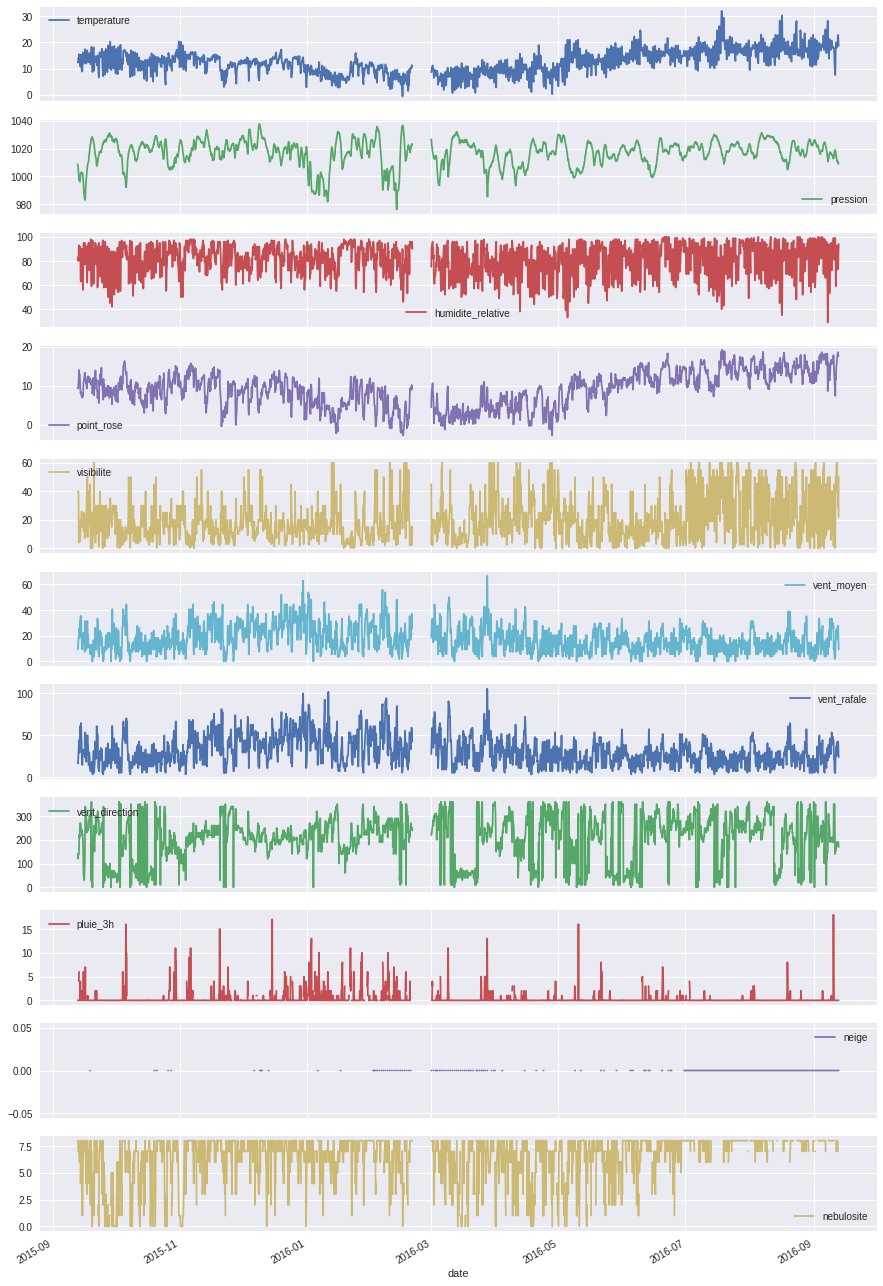

In [12]:
meteo_train.plot(subplots=True, figsize =(15, 25))
plt.show()

**Remarques**:
* On peut bien remarquer les données manquantes sur la tranche du ***2016-02-21 00:00:00 à 2016-02-28 21:00:00***

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


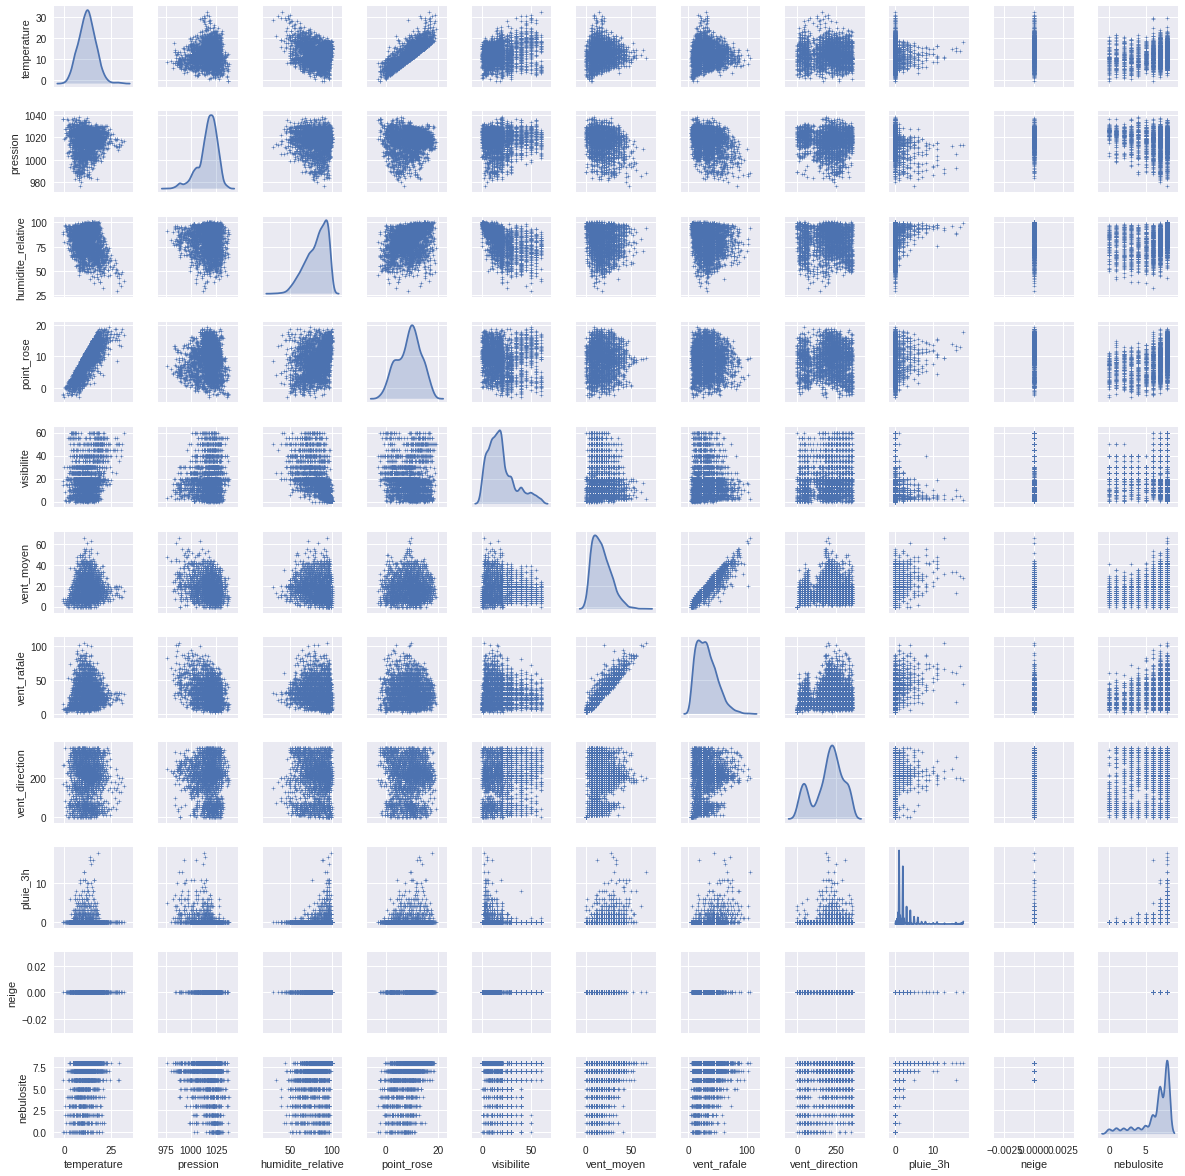

In [13]:
sns.pairplot(meteo_train.reset_index(drop = True), 
             diag_kind="kde",
             markers="+",
             plot_kws=dict(s=20, edgecolor="b", linewidth=0.5),
             diag_kws=dict(shade=True), size = 1.5)

plt.show()

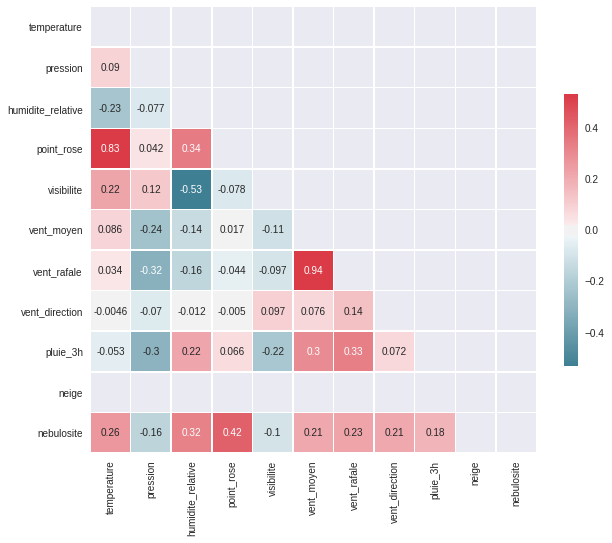

In [14]:
corr = meteo_train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

plt.show()

In [0]:
def plot_rolling(var, maille = "24H", agg = ["mean"]):
  
  var = meteo_train[[var]]
  
  donnee_par_jour = var.rolling(window = maille).agg(agg)
  
  rolling = var.join(donnee_par_jour)
  
  rolling.plot(figsize = (15, 10))
  
  plt.show()



---



#### Temperature

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


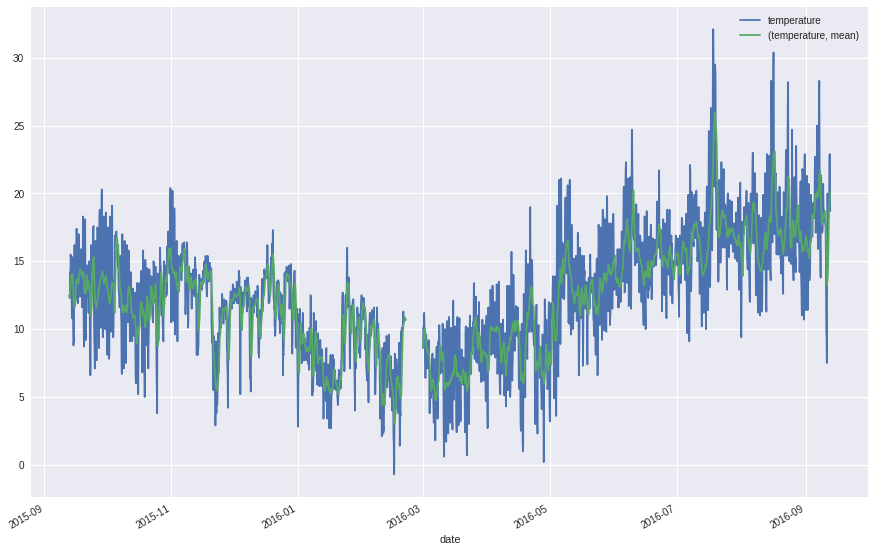

In [16]:
plot_rolling("temperature", maille="24H")

**Remarque**:
* Pour cette serie on peut remarquer deux tendances consécutives

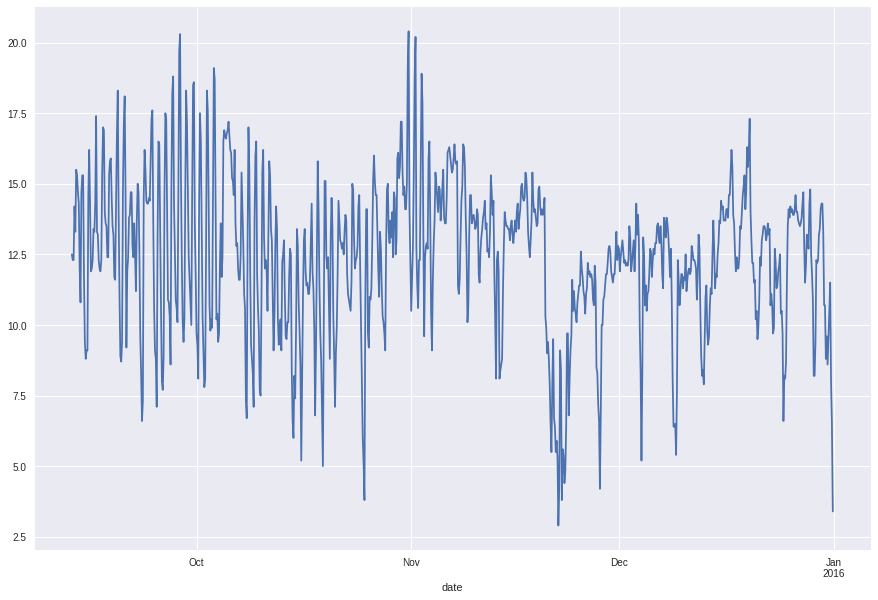

In [17]:
meteo_train.loc["2015", "temperature"].plot(figsize = (15, 10))
plt.show()

**Remarques** :
* On peut remarquer qu'en fin d'annéé 2015 les températures sont moins stable

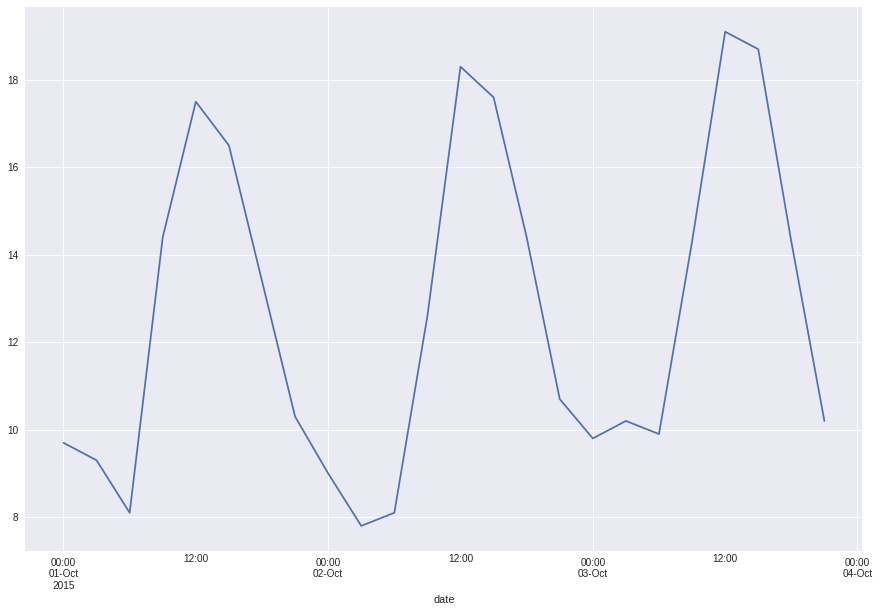

In [18]:
meteo_train.loc["2015-10-01":"2015-10-03", "temperature"].plot(figsize = (15, 10))
plt.show()

#### Pression

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


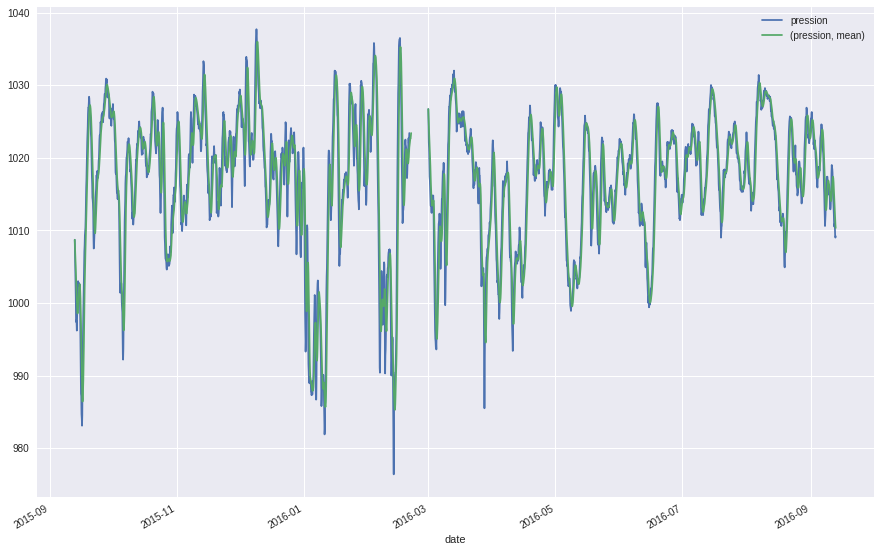

In [19]:
plot_rolling("pression", maille="24H")
plt.show()

**Remarques** :
* Il n'y pas une saisonnalité ny une tendance évidente.
* Par contre la variabilité augmente en fin d'année 2015 puis dimuni

#### Humidité Relative

/usr/local/lib/python3.6/dist-packages/pandas/core/reshape/merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


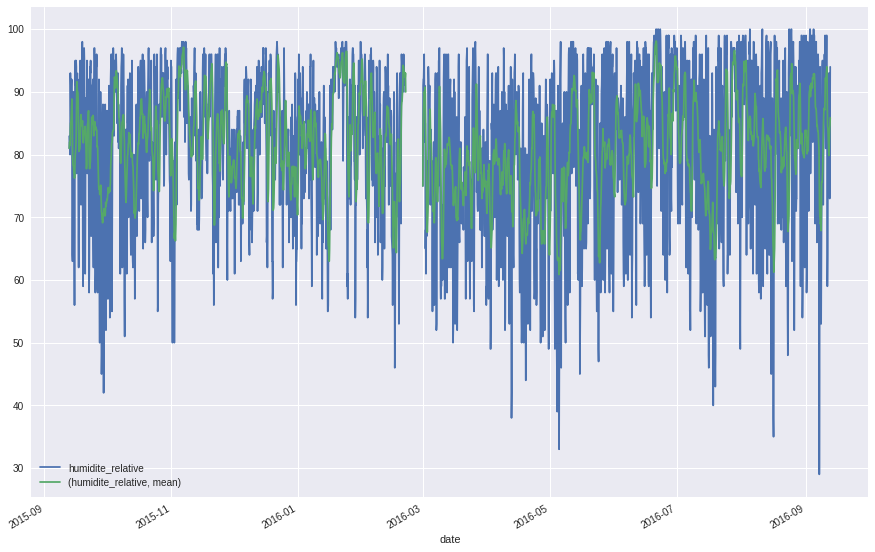

In [20]:
plot_rolling("humidite_relative", maille="24H")
plt.show()

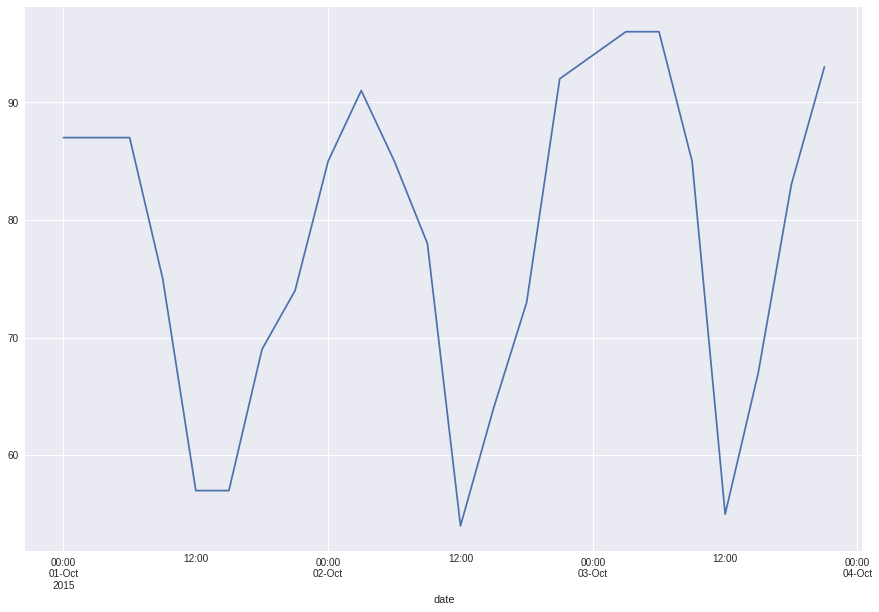

In [21]:
meteo_train.loc["2015-10-01":"2015-10-03", "humidite_relative"].plot(figsize = (15, 10))
plt.show()

#### Direction du vent

NameError: ignored

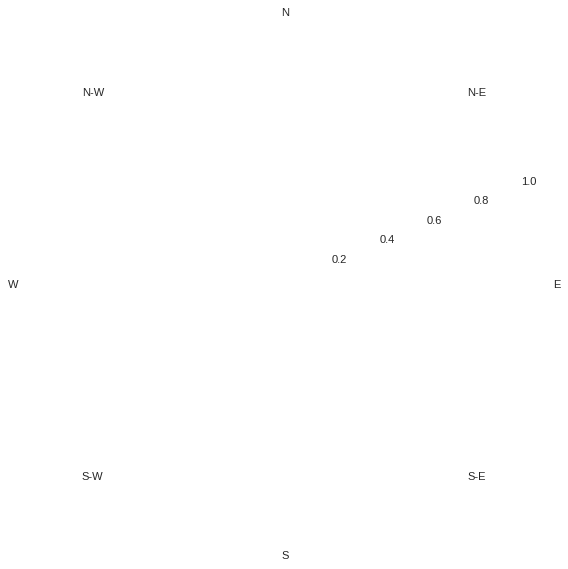

In [22]:
ax = WindroseAxes.from_ax()
ax.contourf(df.vent_direction, df.vent_moyen, cmap=cm.hot)
ax.contour(df.vent_direction, df.vent_moyen, colors='black')
ax.set_legend(loc= "best")
plt.show()

## Exploration des données conso

In [411]:
print(conso_train.info())
print(conso_train.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2015-09-13 00:59:59+02:00 to 2016-09-13 00:00:00+02:00
Data columns (total 1 columns):
puissance    8760 non-null float64
dtypes: float64(1)
memory usage: 456.9 KB
None
                            puissance
date                                 
2015-09-13 00:59:59+02:00  526.166667
2015-09-13 01:59:59+02:00  495.000000
2015-09-13 02:59:59+02:00  446.166667
2015-09-13 03:59:59+02:00  365.833333
2015-09-13 04:59:59+02:00  341.000000


**Remarques**:
* Les données ont désormais comme pour index la date de prélèvement des données.
* Il n'y a aucune données manquantes.
* On remarque que les prélèvements débutent le ***2015-09-13 00:59:59+02:00*** et se termine le ***2016-09-13 00:00:00+02:00***. On peut donc remarquer que les prélèvements étaient faite en fin d'heure (hh:59:59) et à partir d'une certaine date les prélèvelement était fait en debut d"heure (hh:00:00).

---



In [384]:
# Début du 2015-12-31
print("="*13, "2015-12-31","="*13)
print(conso_train["2015-12-31"].head())
print()

# Fin du 2015-12-31
print("...")
print(conso_train["2015-12-31"].tail())
print()

# Début du 2016-01-01
print("="*13, "2016-01-01","="*13)
print(conso_train["2016-01-01"].head())
print()

# Fin du 2016-01-01
print("...")
print(conso_train["2016-01-01"].tail())

print("="*38)

============= 2015-12-31 =============
                             puissance
date                                  
2015-12-31 00:59:59+01:00  1158.666667
2015-12-31 01:59:59+01:00  1076.833333
2015-12-31 02:59:59+01:00  1059.500000
2015-12-31 03:59:59+01:00  1004.666667
2015-12-31 04:59:59+01:00   987.166667

...
                             puissance
date                                  
2015-12-31 18:59:59+01:00  1564.333333
2015-12-31 19:59:59+01:00  1518.166667
2015-12-31 20:59:59+01:00  1612.000000
2015-12-31 21:59:59+01:00  1732.166667
2015-12-31 22:59:59+01:00  1567.500000

============= 2016-01-01 =============
                             puissance
date                                  
2016-01-01 00:00:00+01:00  1453.200000
2016-01-01 01:00:00+01:00  1331.166667
2016-01-01 02:00:00+01:00  1213.500000
2016-01-01 03:00:00+01:00  1145.833333
2016-01-01 04:00:00+01:00  1078.333333

...
                             puissance
date                                  
2016-01-01 19:

**Remarques**:
* Les prélèvements débutait donc à hh:59:59 puis à partir du 1er Janvier 2016 les prélèvements se sont faites à hh:00:00.
* Et donc en 2015 les prélèvements s'éffectuaient de 00:59:59 (disons 1h) à 23:59:59 (disons 0h du jour suivant)
* En 2016 les prélèvements  s'éffectuaient de 00:00:00 à 23:00:00.
* Le 31 Decembre 2015, la donnée de 23:59:59 a été passé au 1er Janvier 2016 du fait de la nouvelle méthode de prélèvement, et donc le jour de 2015-12-31 compte seulement 23 données plutot que 24.
---



In [415]:
print(conso_train.tail())

                            puissance
date                                 
2016-09-12 20:00:00+02:00  533.166667
2016-09-12 21:00:00+02:00  504.000000
2016-09-12 22:00:00+02:00  608.333333
2016-09-12 23:00:00+02:00  509.833333
2016-09-13 00:00:00+02:00  435.000000


**Remarques**:
* Les prélèvements des consomations sont réalisés sont jusqu'au **2016-09-13 00:00:00+02:00**, alors que les données méteo se termine au **2016-02-28 21:00:00**, il faudrait donc supprimer ces données

In [420]:
print("="*13, "2015-10-24","="*13)
print(conso_train["2015-10-25"].head())
print()
print("="*13, "2016-03-27","="*13)
print(conso_train["2016-03-27"].head())

============= 2015-10-24 =============
                            puissance
date                                 
2015-10-25 00:59:59+02:00  792.500000
2015-10-25 01:59:59+02:00  697.000000
2015-10-25 02:59:59+01:00  609.166667
2015-10-25 03:59:59+01:00  589.000000
2015-10-25 04:59:59+01:00  598.333333

============= 2016-03-27 =============
                             puissance
date                                  
2016-03-27 00:00:00+01:00  1284.833333
2016-03-27 01:00:00+01:00  1139.666667
2016-03-27 03:00:00+02:00  1092.000000
2016-03-27 03:00:00+02:00  1092.000000
2016-03-27 04:00:00+02:00  1065.666667


**Remarques** :
* On peut remarquer le change effectuer dans le nuit 25 Octobre 2015
* On peut remarquer le change effectuer dans le nuit 27 Mars 2016

### Visualisation des données conso

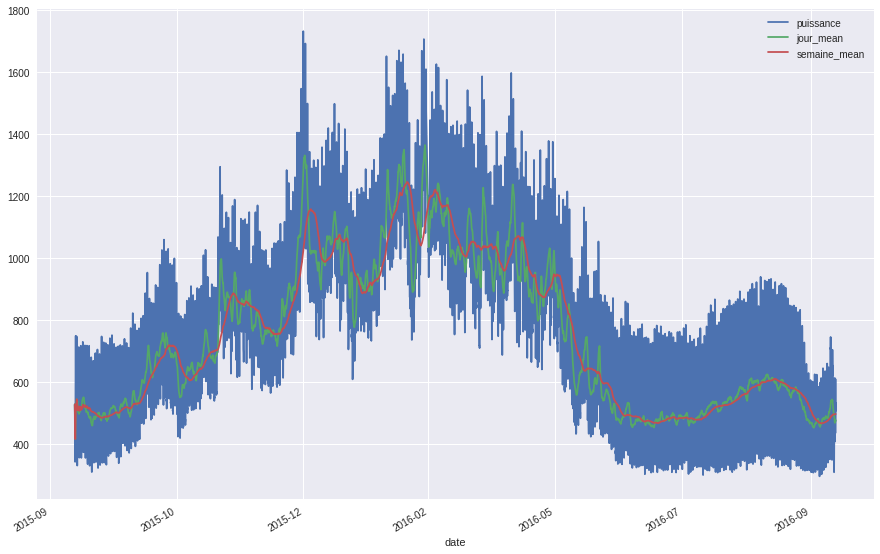

In [421]:
conso_train_day = conso_train["puissance"].rolling(window = "24H").agg(["mean"]).add_prefix("jour_")

conso_train_week = conso_train["puissance"].rolling(window = "7D").agg(["mean"]).add_prefix("semaine_")

rolling = conso_train.join(conso_train_day)

rolling = rolling.join(conso_train_week)

rolling.plot(figsize =(15, 10))

plt.show()

**Remarques**:
* On ne peut pas voir trop de details sur ce graphique, mais en gros on peut voir une augmentation de la consommaton puis une dimunition. Ce qui est normal au vu des saisons

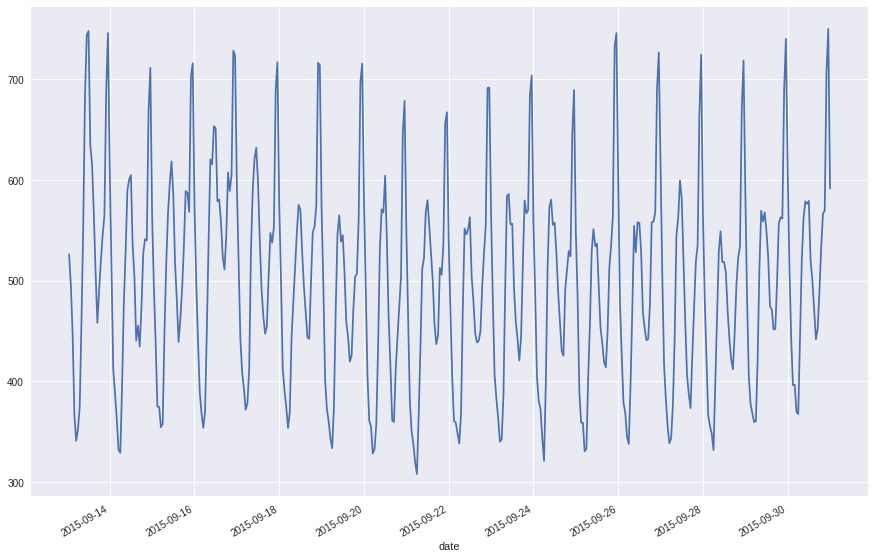

In [425]:
conso_train["puissance"]["2015-09"].plot(figsize =(15, 10))
plt.show()

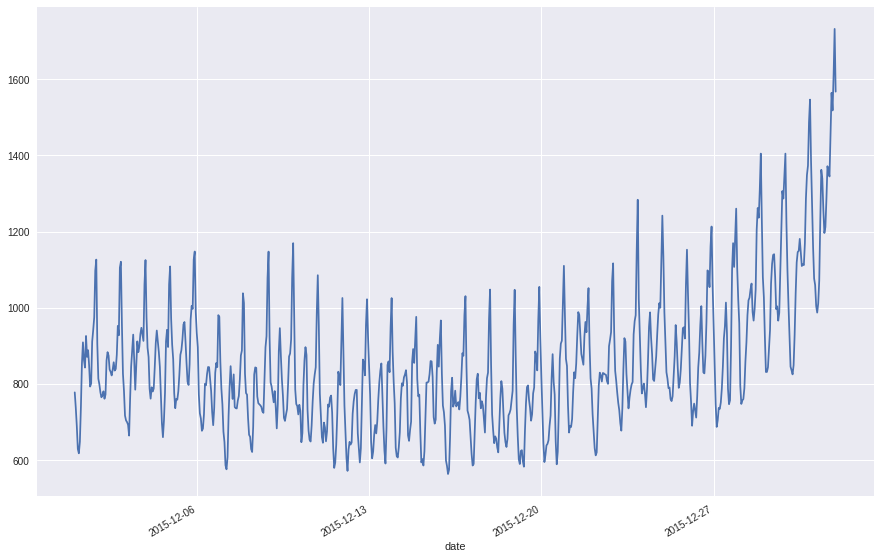

In [183]:
conso_train["puissance"]["2015-12"].plot(figsize =(15, 10))
plt.show()

# Preprocessing

In [0]:
meteo_train_2015 = meteo_train["2015"]
meteo_train_2016 = meteo_train["2016"]

conso_train_2015 = conso_train["2015"]
conso_train_2016 = conso_train["2016"]

In [24]:
meteo_train_2015_with_one = meteo_train_2015.append(meteo_train_2016.iloc[0, :])

meteo_train_2015_resampled = meteo_train_2015_with_one.resample("H").interpolate().iloc[1:-1]

print("2015 lenght match ?", len(meteo_train_2015_resampled) == len(conso_train_2015))

2015 lenght match ? True


In [25]:
meteo_train_2016_resampled = meteo_train_2016.resample("H").interpolate()

date_29_02_2016 = meteo_train_2016_resampled["2016-02-29"].index

meteo_train_2016_resampled.drop(date_29_02_2016, inplace=True)

conso_train_2016_adjusted = conso_train_2016.iloc[:-3]

print("2016 lenght match ?", len(meteo_train_2016_resampled) == len(conso_train_2016_adjusted))

2016 lenght match ? True


In [26]:
mask_meteo = meteo_train_2016_resampled["2016-02-21":"2016-02-28"].index
mask_conso = conso_train_2016_adjusted["2016-02-21":"2016-02-28"].index

meteo_train_2016_resampled.drop(mask_meteo, inplace=True)
conso_train_2016_adjusted.drop(mask_conso, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [27]:
meteo_train_resampled = pd.concat([meteo_train_2015_resampled, meteo_train_2016_resampled])

meteo_train_resampled.drop("neige", axis = 1, inplace=True)

print(meteo_train_resampled.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8565 entries, 2015-09-13 01:00:00 to 2016-09-12 21:00:00
Data columns (total 10 columns):
temperature          8565 non-null float64
pression             8565 non-null float64
humidite_relative    8565 non-null float64
point_rose           8565 non-null float64
visibilite           8565 non-null float64
vent_moyen           8565 non-null float64
vent_rafale          8565 non-null float64
vent_direction       8565 non-null float64
pluie_3h             8565 non-null float64
nebulosite           8565 non-null float64
dtypes: float64(10)
memory usage: 736.1 KB
None


In [28]:
conso_train_resampled = pd.concat([conso_train_2015, conso_train_2016_adjusted])

print(conso_train_resampled.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8565 entries, 2015-09-13 00:59:59+02:00 to 2016-09-12 21:00:00+02:00
Data columns (total 1 columns):
puissance    8565 non-null float64
dtypes: float64(1)
memory usage: 133.8 KB
None


In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [104]:
dataset = pd.concat([meteo_train_resampled.reset_index(drop=True), conso_train_resampled.reset_index(drop=True)], axis = 1)

values = dataset.values

#scaler = MinMaxScaler(feature_range=(0, 1))

scaler = StandardScaler()

scaled = scaler.fit_transform(values[:, :-1])

scaled = np.c_[scaled, values[:, -1]]

reframed = series_to_supervised(scaled, 2, 1)

#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

print(reframed.shape)

(8563, 33)


In [105]:
X_train, X_test, y_train, y_test = train_test_split(reframed.iloc[:, :-1].values, reframed.iloc[:, -1].values, train_size = 0.9, shuffle = False)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.9, shuffle = False)

#X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))

#X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))

#X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape)

(6935, 32) (6935,) (857, 32) (857,) (771, 32) (771,)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 6935 samples, validate on 771 samples
Epoch 1/50
 - 2s - loss: 790.5265 - val_loss: 540.4302
Epoch 2/50
 - 1s - loss: 788.4703 - val_loss: 538.6523
Epoch 3/50
 - 1s - loss: 786.7698 - val_loss: 536.9714
Epoch 4/50
 - 1s - loss: 785.0956 - val_loss: 535.3026
Epoch 5/50
 - 1s - loss: 783.4299 - val_loss: 533.6397
Epoch 6/50
 - 1s - loss: 781.7689 - val_loss: 531.9802
Epoch 7/50
 - 1s - loss: 780.1106 - val_loss: 530.3231
Epoch 8/50
 - 1s - loss: 778.4544 - val_loss: 528.6676
Epoch 9/50
 - 1s - loss: 776.7995 - val_loss: 527.0133
Epoch 10/50
 - 1s - loss: 775.1457 - val_loss: 525.3599
Epoch 11/50
 - 1s - loss: 773.4927 - val_loss: 523.7073
Epoch 12/50
 - 1s - loss: 771.8403 - val_loss: 522.0552
Epoch 13/50
 - 1s - loss: 770.1886 - val_loss: 520.4037
Epoch 14/50
 - 1s - loss: 768.5373 - val_loss: 518.7526
Epoch 15/50
 - 1s - loss: 766.8863 - val_loss: 517.1019
Epoch 16/50
 - 1s - loss: 765.2357 - val_loss: 515.4514
Epoch 17/50
 - 1s - loss: 763.5853 - val_loss: 513.8011
Epoch 18/5

Epoch 42/50
 - 1s - loss: 722.3610 - val_loss: 472.5777
Epoch 43/50
 - 1s - loss: 720.7126 - val_loss: 470.9294
Epoch 44/50
 - 1s - loss: 719.0643 - val_loss: 469.2811
Epoch 45/50
 - 1s - loss: 717.4160 - val_loss: 467.6327
Epoch 46/50
 - 1s - loss: 715.7677 - val_loss: 465.9845
Epoch 47/50
 - 1s - loss: 714.1194 - val_loss: 464.3362
Epoch 48/50
 - 1s - loss: 712.4711 - val_loss: 462.6879
Epoch 49/50
 - 1s - loss: 710.8229 - val_loss: 461.0396
Epoch 50/50
 - 1s - loss: 709.1746 - val_loss: 459.3913


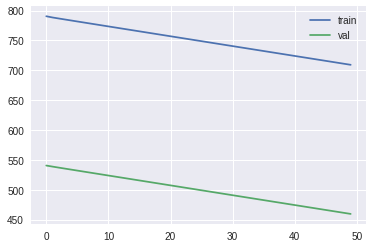

In [100]:
# design network
model = Sequential()
model.add(LSTM(80, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_val, y_val), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [0]:
from keras.layers import SimpleRNN, TimeDistributed
from keras.engine import Model
from keras import Input

input_layer = Input(shape = (X_train.shape[1], X_train.shape[2]))

simple_rnn = LSTM(50)(input_layer)

output_layer = Dense(1)(simple_rnn)

network = Model(inputs = input_layer, outputs = output_layer)

network.compile(optimizer = "adam", loss = "mae")

network.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_val, y_val), verbose=2, shuffle=False)

In [479]:
X = meteo_train_resampled.values
y = conso_train_resampled.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)

n_train_hours = 355 * 24

X_train = X[:n_train_hours, :]
X_test = X[n_train_hours:, :]

y_train = y[:n_train_hours, :]
y_test = y[n_train_hours:, :]

y_train = y_train.flatten()
y_test = y_test.flatten()

# reshape input to be 3D [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(8520, 1, 10) (8520,) (45, 1, 10) (45,)


In [480]:
values = np.c_[X, y]

values.shape

(8565, 11)

In [147]:
reframed = series_to_supervised(values, 1, 1)

#reframed.drop(reframed.columns[[11,12,13,14,15, 16, 17, 18, 19, 20]], axis=1, inplace=True)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.400407   0.514410   0.741784   0.553030   0.666667   0.148148   
2   0.398374   0.501903   0.751174   0.556061   0.666667   0.157407   
3   0.396341   0.489396   0.760563   0.559091   0.666667   0.166667   
4   0.396341   0.480152   0.755869   0.556061   0.666667   0.185185   
5   0.396341   0.470908   0.751174   0.553030   0.666667   0.203704   

   var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)     ...       var2(t)  \
1   0.139394   0.370370   0.000000    1.000000     ...      0.501903   
2   0.133333   0.351852   0.000000    1.000000     ...      0.489396   
3   0.127273   0.333333   0.000000    1.000000     ...      0.480152   
4   0.145455   0.342593   0.024691    0.958333     ...      0.470908   
5   0.163636   0.351852   0.049383    0.916667     ...      0.461664   

    var3(t)   var4(t)   var5(t)   var6(t)   var7(t)   var8(t)   var9(t)  \
1  0.751174  0.556061  0.666667  0.157407  0.133333  0.351852  0.

In [0]:
# design network
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_test, y_test), verbose=2, shuffle=False)

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [118]:
forest_reg = RandomForestRegressor(random_state=42)

forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [119]:
y_test_pred = forest_reg.predict(X_val)

mean_absolute_error(y_test_pred, y_val)

54.974124513628404

In [0]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [121]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)

display_scores(forest_rmse_scores)

Scores: [58.26731334 70.68530858 62.10995743 73.46320705 66.36712051 79.64116607
 66.98297346 83.39625686 83.13650644 78.88608948]
Mean: 72.29358992242786
Standard deviation: 8.402434425247495


In [128]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [30, 50, 100], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=10,
                           scoring='neg_mean_squared_error', return_train_score=True)

grid_search.fit(X_train, y_train)
print()
print(grid_search.best_params_)
print()
print(grid_search.best_estimator_)

cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)


{'max_features': 8, 'n_estimators': 100}

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
121.04804163214929 {'max_features': 2, 'n_estimators': 30}
120.56414135135248 {'max_features': 2, 'n_estimators': 50}
119.91621040401976 {'max_features': 2, 'n_estimators': 100}
99.94930426517026 {'max_features': 4, 'n_estimators': 30}
99.35171021616377 {'max_features': 4, 'n_estimators': 50}
97.78101674417415 {'max_features': 4, 'n_estimators': 100}
87.08130405934224 {'max_features': 6, 'n_estimators': 30}
87.07398386157723 {'max_features': 6, 'n_estimators': 50}
86.28439201775683 {'max_features': 6, 'n_estimators': 100}
80.62984940790236 {'max_features': 8, 'n_estimators'

In [129]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([0.0205333 , 0.00519905, 0.00534583, 0.0315864 , 0.00329316,
       0.00371383, 0.01299854, 0.00373557, 0.00128268, 0.00214088,
       0.21798472, 0.04603427, 0.00504609, 0.00480515, 0.03478411,
       0.00335877, 0.00457297, 0.01111154, 0.00380854, 0.0011912 ,
       0.00253515, 0.45272292, 0.03079262, 0.00461205, 0.00396477,
       0.05629092, 0.0035335 , 0.00526028, 0.01009933, 0.00378122,
       0.00112266, 0.00275798])

In [139]:
final_model = grid_search.best_estimator_

final_model.fit(X_train, y_train)

y_val_pred = final_model.predict(X_val)

print(final_model.score(X_val, y_val))

print(mean_absolute_error(y_val_pred, y_val))

0.5852340648659474
68.91283182015076


In [142]:
y_val_pred.shape

(771,)

In [141]:
y_val.shape

(771,)

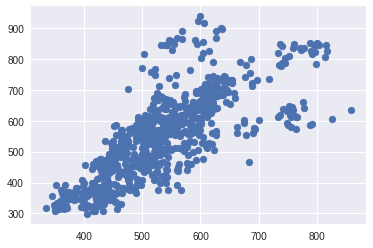

In [169]:
plt.scatter(y_val_pred, y_val)
plt.show()

In [135]:
y_test_pred = final_model.predict(X_test)

print(final_model.score(X_test, y_test))

print(mean_absolute_error(y_test_pred, y_test))

0.6334702651190887
63.822711007383376
